In [1]:
import intake
import numpy as np
import pandas as pd
import xarray as xr
import time
import os
import pyproj
import matplotlib.pyplot as plt

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

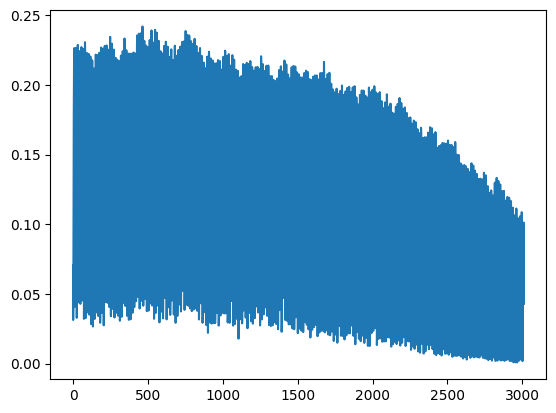

In [32]:
da = xr.open_dataset("/scratch/users/yucli/test/ICEFRAC_memberid0.nc")["__xarray_dataarray_variable__"]

plt.plot(da.mean(dim=("x","y")))

In [2]:
CATALOG = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)


In [3]:
CESM_OCEAN_GRID = xr.open_dataset(f"{DATA_DIRECTORY}/cesm_lens/grids/ocean_grid.nc")

In [9]:

download_settings = {
    # variables to download 
    "vars": ["ICEFRAC", "TEMP", "FLNS", "FSNS", "PSL", "Z3", "U", "V", "hi"],

    "chunk": "default",
    
    "member_id": [0]
}

var_args = {
    "ICEFRAC":  {"p_index": None}, # saved in the atm component
    "TEMP":     {"p_index": 0, "lat_slice": slice(0, 93)}, # note, lat_slice is index 
    "FLNS":     {"p_index": None}, 
    "FSNS":     {"p_index": None}, 
    "PSL":      {"p_index": None}, 
    "Z3":       {"p_index": 20}, 
    "U":        {"p_index": -1}, 
    "V":        {"p_index": -1}, # apparently, there is no V! 
    "hi":       {"p_index": None, "lat_slice": slice(0, 93)} # for some reason thickness is in ice component, not atm
}

variables_to_download = ["ICEFRAC", "TEMP", "FLNS", "FSNS", "PSL", "Z3", "U", "V", "hi"]
test_variables_to_download = ["ICEFRAC"]

saved_subsets = {}

def retrieve_variable_dataset(catalog, variable, verbose=1):
    """
    
    """

    if verbose >= 1: print(f"Finding {variable}...", end="")
    catalog_subset = CATALOG.search(variable=variable, frequency='monthly')

    if len(catalog_subset.df) == 0: 
        if verbose >= 1: print(f"did not find any saved data. Skipping...")
        return None 
        
    if len(catalog_subset.df) != 4: 
        if verbose >= 1: print(f"only found {len(catalog_subset.df)} saved experiments instead of expected (4)")

    dsets = catalog_subset.to_dataset_dict(storage_options={'anon':True})
    if verbose >= 1: print("done! merging datasets...", end="")

    # get the model component and save it to var_args dict 
    component = catalog_subset.df.component[0]
    var_args[variable]["component"] = component 
    
    cmip_hist_ds = dsets.get(f"{component}.historical.monthly.cmip6", None)
    smbb_hist_ds = dsets.get(f"{component}.historical.monthly.smbb", None)
    cmip_ssp_ds = dsets.get(f"{component}.ssp370.monthly.cmip6", None)
    smbb_ssp_ds = dsets.get(f"{component}.ssp370.monthly.smbb", None)

    cmip_merge_ds, smbb_merge_ds = None, None
    if cmip_hist_ds and cmip_ssp_ds:
        cmip_merge_ds = xr.concat([cmip_hist_ds, cmip_ssp_ds], dim='time') 
    if smbb_hist_ds and smbb_ssp_ds: 
        smbb_merge_ds = xr.concat([smbb_hist_ds, smbb_ssp_ds], dim='time')
    if cmip_merge_ds and smbb_merge_ds:
        merged_ds = xr.concat([cmip_merge_ds, smbb_merge_ds], dim='member_id')
    elif cmip_merge_ds:
        merged_ds = cmip_merge_ds
    else:
        raise Exception(f"{variable} seems to be missing CMIP protocol ensemble members")

    if verbose >= 1: print("done! \n")
    return merged_ds 

def subset_variable_dataset(merged_ds, variable, member_id, chunk="default", var_args=var_args):
    print(f"Subsetting ensemble member {member_id}")
    
    component = var_args[variable]["component"]
    subset = merged_ds[variable].isel(member_id=member_id) 
    
    # all the atmospheric variables can be subsetted simply
    if component == "atm":
        subset = subset.sel(lat=slice(-90, -30))
    elif component == "ice":
        subset = subset.sel(nj=var_args[variable]["lat_slice"])
    else: 
        subset = subset.sel(nlat=var_args[variable]["lat_slice"])

    # subset z/p dimension, if it exists
    if var_args[variable]["p_index"] is not None: 
        if component == "ocn":
            subset = subset.isel(z_t=var_args[variable]["p_index"])
        else:
            subset = subset.isel(lev=var_args[variable]["p_index"])

    # add latitude/longitude to ocean and ice variables 
    if component != "atm": 
        if component == "ocn":
            lat_index_name, lon_index_name = "nlat", "nlon"
        elif component == "ice":
            lat_index_name, lon_index_name = "nj", "ni"

        lat = CESM_OCEAN_GRID.lat.sel(nlat=var_args[variable]["lat_slice"]).data
        lon = CESM_OCEAN_GRID.lon.sel(nlat=var_args[variable]["lat_slice"]).data

        subset = subset.assign_coords(lat=([lat_index_name, lon_index_name], lat), lon=([lat_index_name, lon_index_name], lon))
    
    if chunk == "default":
        subset = subset.chunk({"time": 502})
    else: 
        subset = subset.chunk(chunk)
        
    return subset

def generate_sps_grid(grid_size=80, lat_boundary=-52.5):
    # Define the South Polar Stereographic projection (EPSG:3031)
    proj_south_pole = pyproj.Proj(proj='stere', lat_0=-90, lon_0=0, lat_ts=-70)

    # Define the geographic coordinate system (EPSG:4326)
    proj_geographic = pyproj.Proj(proj='latlong', datum='WGS84')

    # Compute the maximum radius from the South Pole in stereographic coordinates
    _, max_radius = proj_south_pole(0, lat_boundary)

    x = np.linspace(-max_radius, max_radius, grid_size)
    y = np.linspace(-max_radius, max_radius, grid_size)
    X, Y = np.meshgrid(x, y)

    lon, lat = pyproj.transform(proj_south_pole, proj_geographic, X, Y)

    output_grid = xr.Dataset(
        {
            "lat": (["y", "x"], lat),
            "lon": (["y", "x"], lon),
        },
        coords={
            "x": (["x"], x),
            "y": (["y"], y),
        }
    )

    return output_grid


def regrid_variable(ds, output_grid):
    weight_file = f'{config.DATA_DIRECTORY}/ERA5/ERA5_to_{grid_name}_bilinear_regridding_weights.nc'

    if os.path.exists(weight_file):
        regridder = xe.Regridder(ds_to_regrid, output_grid, 'bilinear', weights=weight_file, 
                                ignore_degenerate=True, reuse_weights=True, periodic=True)
    else:
        regridder = xe.Regridder(ds_to_regrid, output_grid, 'bilinear', filename=weight_file, 
                                ignore_degenerate=True, reuse_weights=False, periodic=True)

    ds_regridded = regridder(ds_to_regrid)


output_grid = generate_sps_grid()

for variable in download_settings["vars"]:
    merged_ds = retrieve_variable_dataset(catalog=CATALOG, variable=variable)
    
    if merged_ds is None: continue

    # download one ensemble member at a time 
    if download_settings["member_id"] == "all": 
        n_members = merged_ds.member_id.size
    elif type(download_settings["member_id"]) == list: 
        n_members = len(download_settings["member_id"])
    else: raise TypeError("download_settings['member_id'] needs to be a list or 'all'")

    for i in range(n_members):
        subset = subset_variable_dataset(merged_ds, variable, member_id=i, chunk=download_settings["chunk"])
        saved_subsets[variable] = subset 

        
    

    



Finding ICEFRAC...
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


done! merging datasets...done! 

Subsetting ensemble member 0
Finding TEMP...only found 3 saved experiments instead of expected (4)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


done! merging datasets...done! 

Subsetting ensemble member 0
Finding FLNS...
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


done! merging datasets...done! 

Subsetting ensemble member 0
Finding FSNS...
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


done! merging datasets...done! 

Subsetting ensemble member 0
Finding PSL...
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


done! merging datasets...done! 

Subsetting ensemble member 0
Finding Z3...
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


done! merging datasets...done! 

Subsetting ensemble member 0
Finding U...
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


/home/users/yucli/sicpred_env/lib/python3.12/site-packages/dask/array/core.py:4894: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(


done! merging datasets...done! 

Subsetting ensemble member 0


/home/users/yucli/sicpred_env/lib/python3.12/site-packages/dask/array/core.py:4894: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(


Finding V...did not find any saved data. Skipping...
Finding hi...
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


done! merging datasets...done! 

Subsetting ensemble member 0


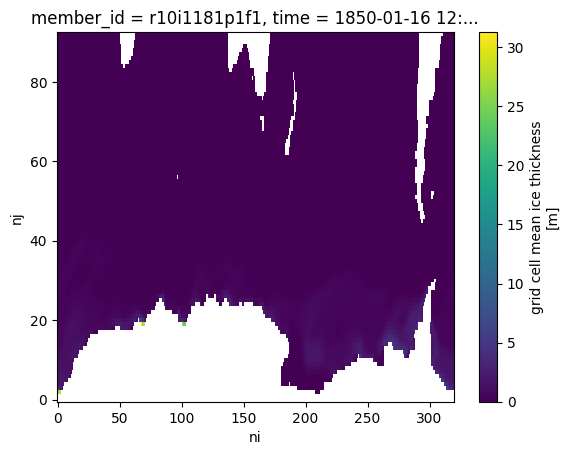

In [50]:
saved_subsets

In [130]:
catalog_subset = catalog.search(variable="U", frequency='monthly')
#dsets = catalog_subset.to_dataset_dict(storage_options={'anon':True})
catalog_subset.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,U,zonal wind,atm,historical,cmip6,monthly,32.0,global,m/s,1850-01-16 12:00:00,2014-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-histo...
1,U,zonal wind,atm,historical,smbb,monthly,32.0,global,m/s,1850-01-16 12:00:00,2014-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-histo...
2,U,zonal wind,atm,ssp370,cmip6,monthly,32.0,global,m/s,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-ssp37...
3,U,zonal wind,atm,ssp370,smbb,monthly,32.0,global,m/s,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-ssp37...


In [40]:
cmip_hist_ds.ICEFRAC.isel(member_id=0, lat=slice(0, 64))

<xarray.DataArray 'ICEFRAC' (time: 1980, lat: 64, lon: 288)> Size: 146MB
dask.array<getitem, shape=(1980, 64, 288), dtype=float32, chunksize=(600, 64, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 512B -90.0 -89.06 -88.12 ... -32.51 -31.57 -30.63
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r10i1181p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Fraction of sfc area covered by sea-ice
    units:         fraction

In [21]:
catalog.search(variable='U', frequency='monthly').df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,U,zonal wind,atm,historical,cmip6,monthly,32.0,global,m/s,1850-01-16 12:00:00,2014-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-histo...
1,U,zonal wind,atm,historical,smbb,monthly,32.0,global,m/s,1850-01-16 12:00:00,2014-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-histo...
2,U,zonal wind,atm,ssp370,cmip6,monthly,32.0,global,m/s,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-ssp37...
3,U,zonal wind,atm,ssp370,smbb,monthly,32.0,global,m/s,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-ssp37...


In [4]:
# list the long names of the variables
catalog.df["long_name"].unique()

array(['FLNS', 'FLNSC', 'FLUT', 'FSNS', 'FSNSC', 'LHFLX', 'PRECC',
       'PRECL', 'PRECSC', 'PRECSL', 'PS', 'PSL', 'Q', 'SHFLX', 'T', 'TMQ',
       'TREFHT', 'TREFHTMN', 'TREFHTMX', 'TS', 'U', 'V', 'Z3', 'FSNTOA',
       'ICEFRAC', nan, 'aice_d', 'hi_d', 'aice', 'hi', 'FSNO', 'H2OSNO',
       'NPP', 'QRUNOFF', 'RAIN', 'SNOW', 'SOILWATER_10CM', 'TREFMXAV',
       'SOILLIQ', 'DIC', 'O2', 'SALT', 'TEMP', 'UES', 'UVEL', 'VNS',
       'VNT', 'WTT', 'WVEL', 'DOC', 'UET', 'PD', 'VVEL', 'WTS'],
      dtype=object)

In [86]:
# search the catalog and load it as a dataframe
catalog_subset = catalog.search(variable='', frequency='monthly')
catalog_subset.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,WTS,salt flux across top face,ocn,ssp370,cmip6,monthly,60.0,global_ocean,gram/kilogram/s,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp37...
1,WTS,salt flux across top face,ocn,ssp370,smbb,monthly,60.0,global_ocean,gram/kilogram/s,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp37...


In [5]:
dsets = catalog_subset.to_dataset_dict(storage_options={'anon':True})


In [6]:
test_retreival = dsets["atm.historical.monthly.cmip6"].isel(member_id=0, time=0).ICEFRAC.load()

In [7]:
test_retreival

<xarray.DataArray 'ICEFRAC' (lat: 192, lon: 288)> Size: 221kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.9966427 , 0.9965812 , 0.9965238 , ..., 0.996822  , 0.9967614 ,
        0.9967035 ],
       [0.99736124, 0.9973296 , 0.9972962 , ..., 0.9974618 , 0.9974287 ,
        0.9973945 ],
       [0.99771273, 0.99771106, 0.9977095 , ..., 0.9977187 , 0.99771655,
        0.9977145 ]], dtype=float32)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r10i1181p1f1'
    time       object 8B 1850-01-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Fraction of sfc area covered by sea-ice
    units:         fraction

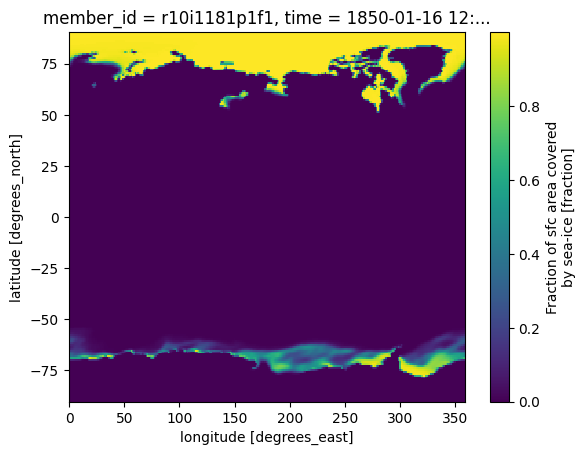

In [8]:
test_retreival.plot()

In [9]:
# let's do a test to see how long it takes to load 120 months (10 yrs)
%time
test_retreival_larger = dsets["atm.historical.monthly.cmip6"].isel(member_id=0, time=slice(0,120)).ICEFRAC.load()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [10]:
# let's do a test to see how long it takes to load 1200 months (10 yrs)
%time
test_retreival_larger = dsets["atm.historical.monthly.cmip6"].isel(member_id=0, time=slice(0,1200)).ICEFRAC.load()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


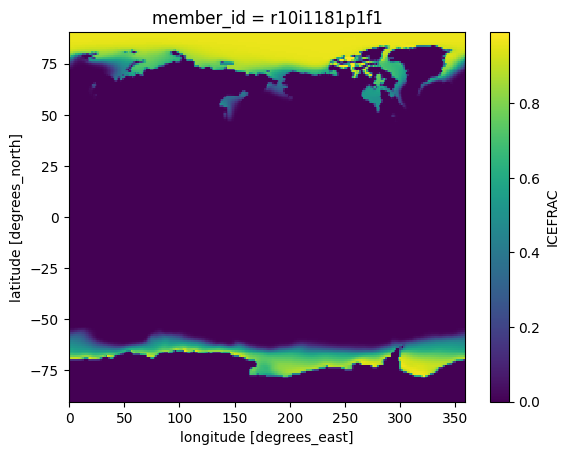

In [11]:
test_retreival_larger.mean("time").plot()

## what about other variables?

In [12]:
variables = catalog.df["variable"]
long_names = catalog.df["long_name"]
for i in range(len(variables)):
    print(variables[i], long_names[i])

FLNS net longwave flux at surface
FLNSC clearsky net longwave flux at surface
FLUT upwelling longwave flux at top of model
FSNS net solar flux at surface
FSNSC clearsky net solar flux at surface
LHFLX surface latent heat flux
PRECC convective precipitation rate (liq + ice)
PRECL large-scale (stable) precipitation rate (liq + ice)
PRECSC convective snow rate (water equivalent)
PRECSL large-scale (stable) snow rate (water equivalent)
PS surface pressure
PSL sea level pressure
Q specific humidity
SHFLX surface sensible heat flux
T temperature
TMQ total (vertically integrated) precipitable water
TREFHT reference height temperature
TREFHTMN minimum reference height temperature over output period
TREFHTMX maximum reference height temperature over output period
TS surface temperature (radiative)
U zonal wind
V meridional wind
Z3 geopotential height (above sea level)
FLNS net longwave flux at surface
FLNSC clearsky net longwave flux at surface
FLUT upwelling longwave flux at top of model
FSNS 

In [13]:
catalog_subset = catalog.search(variable="TEMP")
dsets_temp = catalog_subset.to_dataset_dict(storage_options={'anon':True})


In [14]:
sst_retrieval = dsets_temp["ocn.historical.monthly.cmip6"].isel(member_id=0, time=0, z_t=0).TEMP.load()

In [15]:
sst_retrieval

<xarray.DataArray 'TEMP' (nlat: 384, nlon: 320)> Size: 492kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.8918766, -1.8914382, -1.8911846, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    member_id  <U12 48B 'r10i1181p1f1'
    time       object 8B 1850-01-16 12:00:00
    z_t        float32 4B 500.0
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

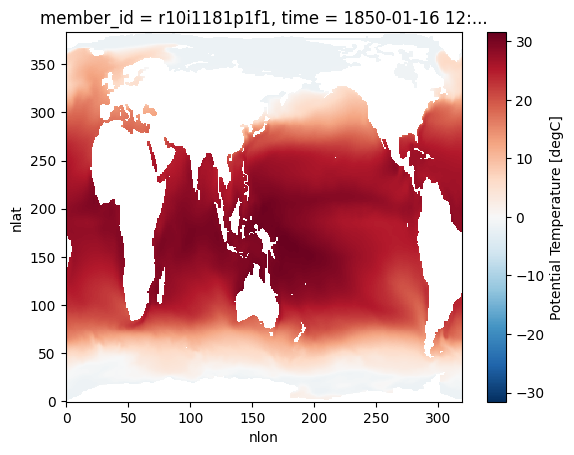

In [16]:
sst_retrieval.plot()

In [148]:
# test a regridder 
SPS_GRID = xr.open_dataset(os.path.join(DATA_DIRECTORY, 'NSIDC/sps_grid.nc'))


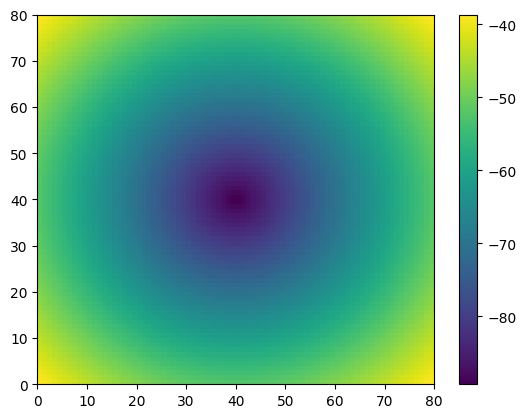

In [159]:
plt.pcolormesh(lat)
plt.colorbar()

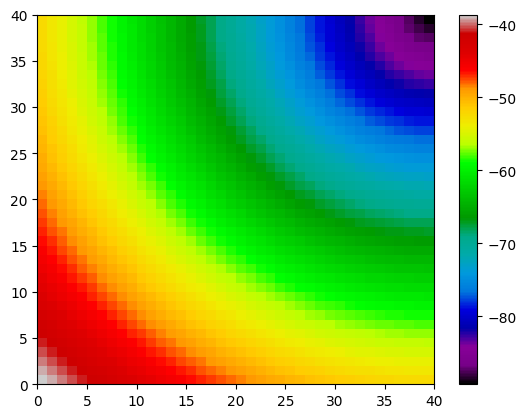

In [173]:
plt.pcolormesh(lat[0:40, 0:40], cmap="nipy_spectral")
plt.colorbar()

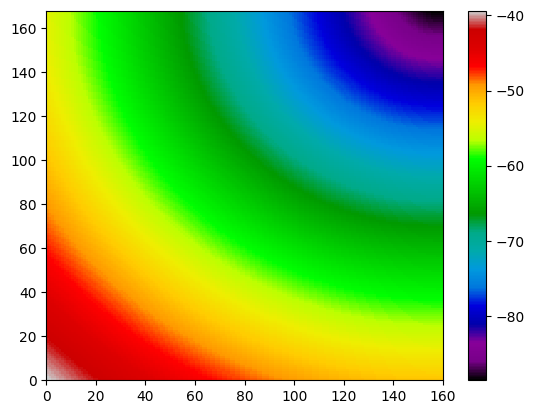

In [186]:
plt.pcolormesh(SPS_GRID.latitude[0:168, 0:160], cmap="nipy_spectral")
plt.colorbar()

In [81]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)


In [92]:
result = esgf_search(activity_id='CMIP', table_id='Omon', variable='thetao', experiment_id='piControl',
                  institution_id="NCAR", source_id="CESM2", member_id="r1i1p1f1")
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable=thetao&experiment_id=piControl&institution_id=NCAR&source_id=CESM2&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable=thetao&experiment_id=piControl&institution_id=NCAR&source_id=CESM2&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable=thetao&experiment_id=piControl&institution_id=NCAR&source_id=CESM2&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable=thetao&experiment_id=piControl&institution_id=NCAR&source_id=CESM2&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/thetao/gn/v20190320/thetao_Omon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/thetao/gn/v20190320/thetao_Omon_CESM2_piControl_r1i1p1f1_gn_010001-019912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/thetao/gn/v20190320/thetao_Omon_CESM2_piControl_r1i1p1f1_gn_020001-029912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/thetao/gn/v20190320/thetao_Omon_CESM2_piControl_r1i1p1f1_gn_030001-039912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/thetao/gn/v20190320/thetao_Omon_CESM2_piControl_r1i1p1f1_gn_040001-049912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/thetao/gn/v20190320/thetao_Omon_CES

In [93]:
len(result)

72

In [96]:
ds = xr.open_dataset(result[0])
ds.isel(lev=0, time=0)

/home/users/yucli/sicpred_env/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'thetao' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 6MB
Dimensions:    (nlat: 384, nlon: 320, d2: 2, vertices: 4)
Coordinates:
    lev        float64 8B 500.0
  * nlat       (nlat) int32 2kB 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1kB 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
    time       object 8B 0001-01-15 13:00:00
    lat        (nlat, nlon) float64 983kB ...
    lon        (nlat, nlon) float64 983kB ...
Dimensions without coordinates: d2, vertices
Data variables:
    time_bnds  (d2) object 16B ...
    lat_bnds   (nlat, nlon, vertices) float32 2MB ...
    lon_bnds   (nlat, nlon, vertices) float32 2MB ...
    lev_bnds   (d2) float32 8B ...
    thetao     (nlat, nlon) float32 492kB ...
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    case_id:                         3
    cesm_casename:                   b.e21.B1850.f09_g17.CMIP6-piControl.001
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-01-20T21:46:07Z
    ...                              ...
    variant_info:                    CMIP6 CESM2 piControl experiment with CA...
    variant_label:                   r1i1p1f1
    branch_time_in_parent:           48545.0
    branch_time_in_child:            0.0
    branch_method:                   standard
    DODS_EXTRA.Unlimited_Dimension:  time